In [5]:
from vgg_pretrained import vgg_preloaded, MelaData, train, train_val_test_split, test_model
import pickle
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
data_d = '/home/paperspace/projects/skin_cancer/data/skin-cancer-mnist-ham10000/HAM10000_images_part_1/'
label_dir = '/home/paperspace/projects/skin_cancer/data/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'
save_dir = '/home/paperspace/projects/skin_cancer/data/res_model/'
epoch = 500
mb = 12
num_class = 7
num_workers = 1
cuda = True
conti = False
final_save = True
name = 'test_model'
lr = 1e-6
stage = 'transfer'
save_freq = 50

In [5]:
loss_train, acc_train, val_data = train(data_dir = data_d, label_dir = label_dir,
                                        save_dir = save_dir, epoch = epoch, mb = mb,
                                        num_class = num_class, num_workers = num_workers,
                                        use_cuda = cuda, conti = conti, lr = lr,
                                        final_save = final_save, name = name, save_freq = save_freq)


[Epoch 1]: 100%|██████████| 585/585 [02:56<00:00,  3.32it/s]


Train - Loss: 1.2513 Acc: 0.6147


Loading the 100th epoch model and run test function

In [6]:
conti = True
save_freq = 5
model_name = 'test_model_100_loss_0_1995_acc_0_9248.pt'
name = save_dir + model_name
lr = 1e-6
epoch = 1

In [8]:
res = test_model(model_dir = name, val_data = val_data,
                 label_dir = label_dir, batch_size = 12,
                 use_cuda = cuda)

[Epoch Validation]: 100%|██████████| 251/251 [01:07<00:00,  3.74it/s]

Loss: 0.2328 Acc: 0.9208


In [14]:
with open(save_dir + 'validation_res.pickle', 'wb') as handle:
    pickle.dump(res, handle)

## Classification result

In [8]:
from collections import Counter
Counter(res['predictions'])

Counter({0: 2043, 1: 305, 2: 303, 3: 35, 4: 103, 5: 173, 6: 42})

## Ground Truth

In [12]:
Counter([item for sublist in res['classes'] for item in sublist])

Counter({0: 2042, 1: 318, 2: 313, 3: 37, 4: 103, 5: 154, 6: 37})

In [17]:
res['loss']

0.23762969305607354

In [9]:
with open(save_dir + 'validation_res.pickle', 'rb') as handle:
    test_res = pickle.load(handle)

In [13]:
y_pred = test_res['predictions']
y_true = test_res['classes']

In [17]:
y_true = [item for sublist in y_true for item in sublist]

In [20]:
conf_mat = confusion_matrix(y_true, y_pred)

In [21]:
conf_mat

array([[1965,   41,   16,    3,    4,   10,    3],
       [  47,  246,   13,    0,    5,    6,    1],
       [  27,   16,  261,    0,    7,    1,    1],
       [   0,    2,    4,   28,    1,    2,    0],
       [   1,    0,    7,    4,   85,    6,    0],
       [   2,    0,    2,    0,    1,  148,    1],
       [   1,    0,    0,    0,    0,    0,   36]])

In [49]:
truth = conf_mat.sum(axis = 0)
preds = conf_mat.sum(axis = 1)

In [41]:
conf_mat_perc_truth = np.array([arr/truth[i] for i, arr in enumerate(conf_mat)])

In [50]:
conf_mat_perc_preds = np.array([arr/preds[i] for i, arr in enumerate(conf_mat)])

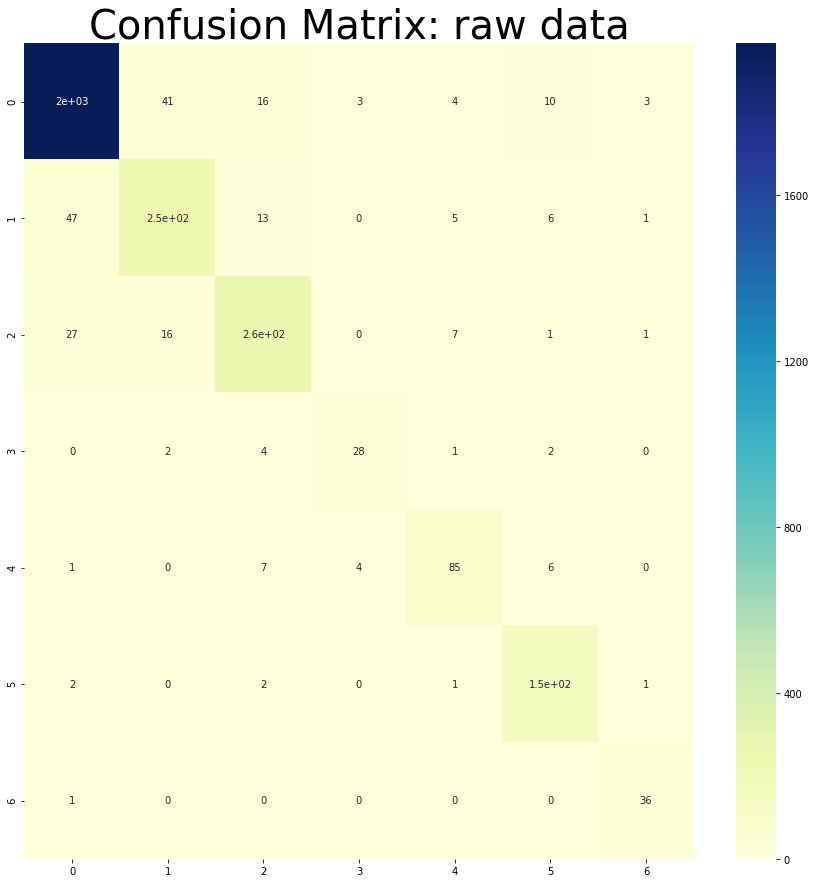

In [48]:
df_cm = pd.DataFrame(conf_mat, index = [i for i in range(7)],
                  columns = [i for i in range(7)])
plt.figure(figsize = (15,15))
plt.title('Confusion Matrix: raw data', fontsize=40)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="YlGnBu")

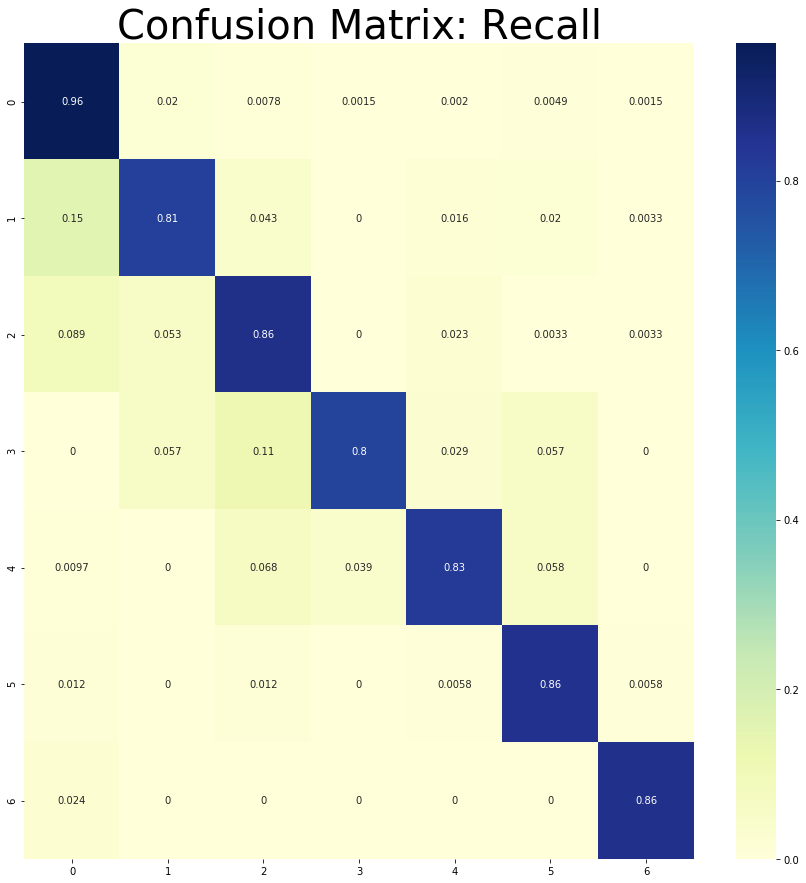

In [46]:
df_cm = pd.DataFrame(conf_mat_perc_truth, index = [i for i in range(7)],
                  columns = [i for i in range(7)])
plt.figure(figsize = (15,15))
plt.title('Confusion Matrix: Recall', fontsize=40)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="YlGnBu")

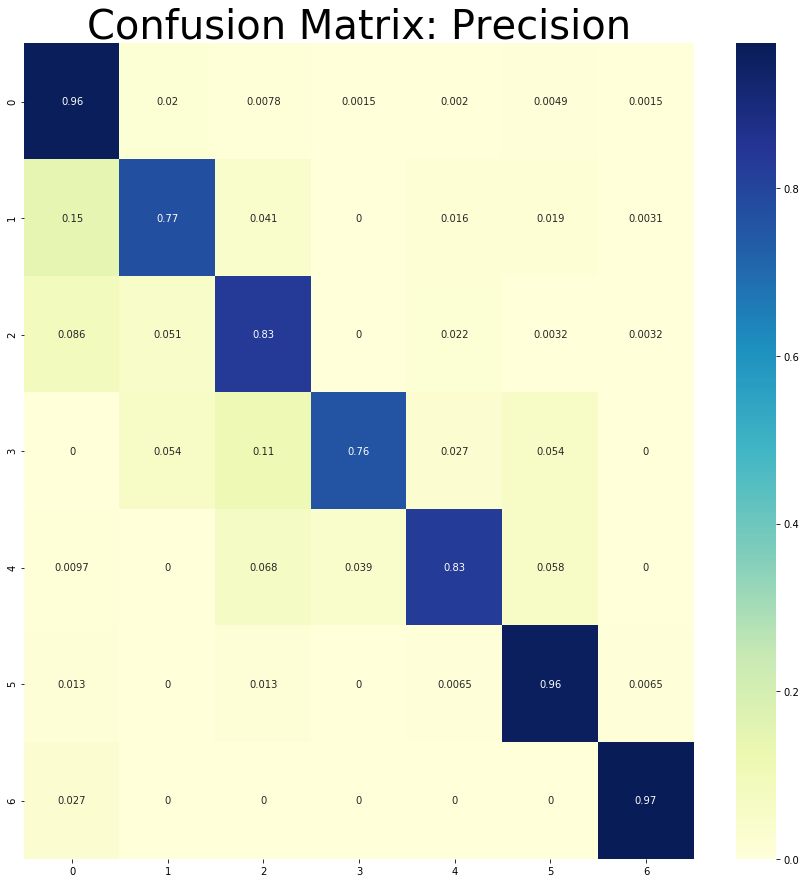

In [51]:
df_cm = pd.DataFrame(conf_mat_perc_preds, index = [i for i in range(7)],
                  columns = [i for i in range(7)])
plt.figure(figsize = (15,15))
plt.title('Confusion Matrix: Precision', fontsize=40)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="YlGnBu")

### Comparison
- Test loss: 0.238 // Test acc: 92%
-

## Class Activation Map

In [4]:
from class_activation_map import ExtractFeatures, GradCam
import cv2
import numpy as np

In [5]:
def preprocess_image(img):
    means=[0.485, 0.456, 0.406]
    stds=[0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[: , :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)

    inp = preprocessed_img
    inp.requires_grad = True
    return(inp)

In [6]:
model = vgg_preloaded(7, use_cuda = cuda)
model.load_state_dict(torch.load(name))
model.model.requires_grad = True

In [60]:
image_path = '/home/paperspace/projects/skin_cancer/data/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0029319.jpg'
img = cv2.imread(image_path, 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255

In [61]:
inp = preprocess_image(img)

In [62]:
inp = inp.cuda()
model = model.cuda()

In [63]:
target_layers = '29'
gradcam = GradCam(model.model, target_layers)

In [64]:
cam = gradcam.generate_CAM(inp)

#### loading original img

In [65]:
image_path = '/home/paperspace/projects/skin_cancer/data/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0029319.jpg'
img = cv2.imread(image_path, 1)
#img = np.float32(cv2.resize(img, (224, 224))) / 255
img = np.float32(img) / 255

In [66]:
heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
cam_ = heatmap + np.float32(img)
cam_ = cam_ / np.max(cam_)

In [67]:
cv2.imwrite("cam_ISIC_0029319.jpg", np.uint8(255 * cam_))

True

In [11]:
code2name = {"akiec":'Actinic_keratoses_and_intraepithelial_carcinoma', 'bcc':'basal_cell_carcinoma', 'bkl': 'solar_lentigines_seborrheic_keratoses_and_lichen_planus_like_keratoses', 'df': 'dermatofibroma', 'mel':'melanoma', 'nv': 'melanocytic_nevi', 'vasc':'vascular_lesions'}   
        

In [12]:
pdmeta = pd.read_csv(label_dir)

In [13]:
pdmeta['cancer_name'] = [code2name[dx] for dx in pdmeta.dx]

In [16]:
pdmeta.to_csv(label_dir)

In [21]:
code2num = {'nv' : 0, 'mel': 1, 'bkl': 2, 'df': 3, 'akiec': 4, 'bcc': 5, 'vasc' : 6}
num2code = {v:k for k,v in code2num.items()}

In [20]:
code2num, code2name

({'akiec': 4, 'bcc': 5, 'bkl': 2, 'df': 3, 'mel': 1, 'nv': 0, 'vasc': 6},
 {'akiec': 'Actinic_keratoses_and_intraepithelial_carcinoma',
  'bcc': 'basal_cell_carcinoma',
  'bkl': 'solar_lentigines_seborrheic_keratoses_and_lichen_planus_like_keratoses',
  'df': 'dermatofibroma',
  'mel': 'melanoma',
  'nv': 'melanocytic_nevi',
  'vasc': 'vascular_lesions'})

In [22]:
num2code

{0: 'nv', 1: 'mel', 2: 'bkl', 3: 'df', 4: 'akiec', 5: 'bcc', 6: 'vasc'}

In [23]:
num2name = {k:code2name[v] for k,v in num2code.items()}

In [24]:
num2name

{0: 'melanocytic_nevi',
 1: 'melanoma',
 2: 'solar_lentigines_seborrheic_keratoses_and_lichen_planus_like_keratoses',
 3: 'dermatofibroma',
 4: 'Actinic_keratoses_and_intraepithelial_carcinoma',
 5: 'basal_cell_carcinoma',
 6: 'vascular_lesions'}

In [25]:
import pickle

In [26]:
with open('num2name.pickle','wb') as handle:
    pickle.dump(num2name, handle)